In [101]:
import numpy as np
import pandas as pd

import librosa
import librosa.display as ld

import glob

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('instruments.csv')
df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


In [10]:
instrument_types = df['label'].value_counts()
print(instrument_types)

Bass_drum           30
Snare_drum          30
Clarinet            30
Violin_or_fiddle    30
Flute               30
Acoustic_guitar     30
Hi-hat              30
Cello               30
Saxophone           30
Double_bass         30
Name: label, dtype: int64


In [95]:
instruments = df['label'].unique()
instruments

array(['Saxophone', 'Violin_or_fiddle', 'Hi-hat', 'Snare_drum',
       'Acoustic_guitar', 'Double_bass', 'Cello', 'Bass_drum', 'Flute',
       'Clarinet'], dtype=object)

In [88]:
class Config:
    sr = 44100
    random_state = 42

In [92]:
def extract_mfcc(file):
    signal, sr = librosa.load(file, Config.sr)
    return librosa.feature.mfcc(y=signal, sr=sr)

In [131]:
mfccs = [extract_mfcc(f'wavfiles/{df[df.label == instrument].iloc[0,0]}') for instrument in instruments]

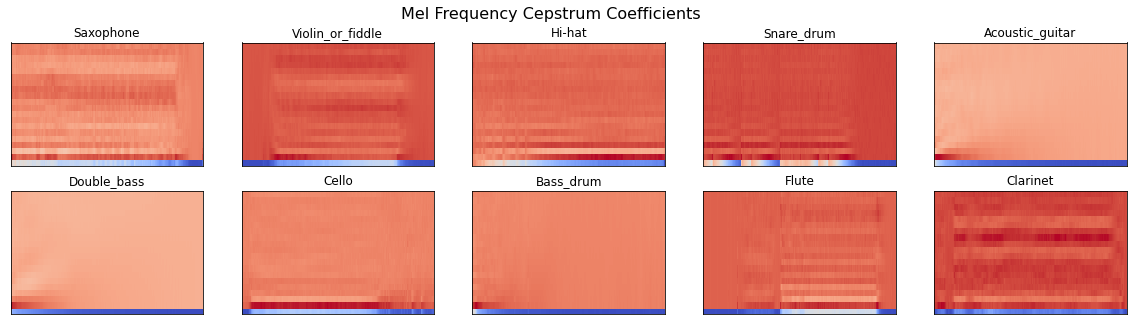

In [126]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
for i, instrument in enumerate(instruments):
    row = 0 if i < 5 else 1
    col = i % 5
    axis = ax[row, col]
    axis.set(title = f'{instrument}')
    axis.get_xaxis().set_visible(False)
    i = librosa.display.specshow(mfccs[i], x_axis='time', ax=ax[row, col])
# plt.colorbar(i)

In [150]:
class InstrumentClassifier:
    def __init__(self, n_samples, features = ['mfcc']):
        self.n_samples = n_samples
        self.features = features
        SVC = Pipeline([
            ('Standard Scaler', StandardScaler()),
            ('PCA', PCA(n_components = 10)),
            ('SVM', svm.SVC(gamma = 'auto'))
        ])

        GNB = Pipeline([
            ('Standard Scaler', StandardScaler()),
            ('PCA', PCA(n_components = 10)),
            ('Gaussian Naive Bayes', GaussianNB())
        ])
        self.pipe_dict = {0: 'SVC', 1: 'GNB'}
        self.pipelines = [SVC, GNB]

    def _extract_mfcc(self, signal, sr):
        mfccs = librosa.feature.mfcc(y=signal, sr=sr)
        aver = np.mean(mfccs, axis = 1)
        feature = aver.reshape(20)
        return feature

    def _extract_melspectrogram(self, signal, sr):
        spectrogram = librosa.feature.melspectrogram(signal)
        spectrogram = librosa.power_to_db(spectrogram)
        spectrogram = spectrogram.astype(np.float32)
        spectrogram = np.mean(spectrogram, axis=1)
        return spectrogram

    def _extract(self, row):
        signal, sr = librosa.load(f'wavfiles/{row[0]}', Config.sr)
        if 'mfcc' in self.features:
            X = self._extract_mfcc(signal, sr)
        if 'melspectrogram' in self.features:
            X = self._extract_melspectrogram(signal, sr)
        X_y = np.append(X, row[1])
        return X_y

    def _extract_X_y(self, df):
        samples = df.sample(n=self.n_samples, replace=True, random_state=Config.random_state)
        data = samples.apply(self._extract, axis=1, result_type='expand')
        X = data.iloc[:,:-1]
        y = data.iloc[:,-1]
        return X, y

    def extract_features(self, df):
        X, y = self._extract_X_y(df)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=Config.random_state)

    def fit(self):
        for p in self.pipelines:
            p.fit(self.x_train, self.y_train)
    
    def perf(self):
        print(f'n_samples:{self.n_samples}, features: {self.features}')
        for i,model in enumerate(self.pipelines):
            print('{} Accuracy: {}'.format(self.pipe_dict[i], model.score(self.x_test, self.y_test)))


In [151]:
for feature in ['mfcc', 'melspectrogram']:
    for samples in [128, 256]:#, 512, 1024
        classifier = InstrumentClassifier(samples, [feature])
        classifier.extract_features(df)
        classifier.fit()
        classifier.perf()


n_samples:128, features: ['mfcc']
SVC Accuracy: 0.5625
GNB Accuracy: 0.59375
n_samples:256, features: ['mfcc']
SVC Accuracy: 0.71875
GNB Accuracy: 0.578125
n_samples:128, features: ['melspectrogram']
SVC Accuracy: 0.53125
GNB Accuracy: 0.6875
n_samples:256, features: ['melspectrogram']
SVC Accuracy: 0.75
GNB Accuracy: 0.609375
